# Lab 2: Building a Travel Planner with a Simple LangGraph

## Overview

This lab guides you through the process of creating a simple Travel Planner using LangGraph, a library for building stateful, multi-step applications with language models. The Travel Planner demonstrates how to structure a conversational AI application that collects user input and generates personalized travel itineraries.

#### What gets covered in this lab: 
we wil cover these aspects below:
- LangGraph constructs for how to build Agentic systems with Graph
- Introduction to short term and long term memory for 'turn-by-turn' conversations

## Intro to Agents

Agents are intelligent systems or components that utilize Large Language Models (LLMs) to perform tasks in a dynamic and autonomous manner. Here's a breakdown of the key concepts:

### What Are Agents?
1. Step-by-Step Thinking: Agents leverage LLMs to think and reason through problems in a structured way, often referred to as chain-of-thought reasoning. This allows them to plan, evaluate, and execute tasks effectively.
2. Access to Tools: Agents can utilize external tools (e.g., calculators, databases, APIs) to enhance their decision-making and problem-solving capabilities.
3. Access to Memory: Agents can store and retrieve context, enabling them to work on tasks over time, adapt to user interactions, and handle complex workflows.

**Key characteristics of AI agents include:**

**Perception:** The ability to gather information from their environment through sensors or data inputs.
**Decision-making:** Using AI algorithms to process information and determine the best course of action.
**Action:** The capability to execute decisions and interact with the environment or users.
**Learning:** The ability to improve performance over time through experience and feedback.
**Autonomy:** Operating independently to some degree, without constant human intervention.
**Goal-oriented:** Working towards specific objectives or tasks.

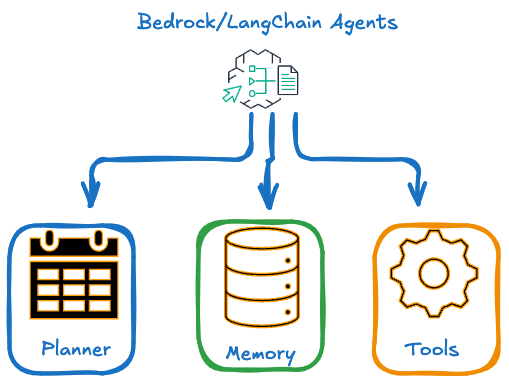

## Use Case Details

Our Travel Planner follows a straightforward, three-step process:

1. **Initial User Input**: 
   - The application prompts the user to enter their desired travel plan to get assistance from AI Agent.
   - This information is stored in the state.

2. **Interests Input**:
   - The user is asked to provide their interests for the trip.
   - These interests are stored as a list in the state.

3. **Itinerary Creation**:
   - Using the collected city and interests, the application leverages a language model to generate a personalized day trip itinerary.
   - The generated itinerary is presented to the user.

The flow between these steps is managed by LangGraph, which handles the state transitions and ensures that each step is executed in the correct order.

### Setup and Imports

First, let's import the necessary modules and set up our environment.

In [1]:
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

## LangGraph Basics

### Key Components

1. **StateGraph**
   - This object will encapsulate the graph being traversed during excecution.
   - The core of our application, defining the flow of our Travel Planner.
   - PlannerState, a custom type representing the state of our planning process.

2. **Nodes**
    - In LangGraph, nodes are typically python functions.
    - There are two main nodes we will use for our graph:
        - The agent node: responsible for deciding what (if any) actions to take.
        - The tool node: This node will orchestrate calling the respective tool and returning the output. 
4. **Edges**
   - Defines how the logic is routed and how the graph decides to stop.
   - Defines how your agents work and how different nodes communicate with each other.
   - There are a few key types of edges:
        - Normal Edges: Go directly from one node to the next.
        - Conditional Edges: Call a function to determine which node(s) to go to next.
        - Entry Point: Which node to call first when user input arrives.
        - Conditional Entry Point: Call a function to determine which node(s) to call first when user input arrives.

4. **LLM Integration**: Utilizing a language model to generate the final itinerary.
5. **Memory Integration**: Utilizing long term and short term memory for conversations

### Define Agent State

We'll define the state that our agent will maintain throughout its operation. First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.  The State schema serves as the input schema for all Nodes and Edges in the graph.

In [2]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    itinerary: str
    city: str
    user_message: str

### Set Up Language Model and Prompts


In [3]:
from langchain_aws import ChatBedrockConverse
import boto3
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables.config import RunnableConfig
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2")
model_id = "us.amazon.nova-lite-v1:0"
provider_id = "amazon"

llm = ChatBedrockConverse(
    model=model_id,
    provider=provider_id,
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
)

itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests. 
    Follow these instructions:
    1. Use the below chat conversation and the latest input from Human to get the user interests.
    2. Always account for travel time and meal times - if its not possible to do everything, then say so.
    3. If the user hasn't stated a time of year or season, assume summer season in {city} and state this assumption in your response.
    4. If the user hasn't stated a travel budget, assume a reasonable dollar amount and state this assumption in your response.
    5. Provide a brief, bulleted itinerary in chronological order with specific hours of day."""),
    MessagesPlaceholder("chat_history"),
    ("human", "{user_message}"),
])

### Define the nodes and Edges

We are adding the nodes, edges as well as a persistant memory to the ```StateGraph``` before we compile it. 
- user travel plans
- invoke with Bedrock
- generate the travel plan for the day 
- ability to add or modify the plan

In [ ]:
def input_interests(state: PlannerState) -> PlannerState:
    user_message = state['user_message'] #input("Your input: ")
    #print(f"We are going to :: {user_message}:: for trip to {state['city']} based on your interests mentioned in the prompt....")

    if not state.get('messages', None) : state['messages'] = []
    return {
        **state,
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], user_message=state['user_message'], chat_history=state['messages']))
    print("\nFinal Itinerary:")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [HumanMessage(content=state['user_message']), AIMessage(content=response.content)],
        "itinerary": response.content
    }

### Create and Compile the Graph

Now we'll create our LangGraph workflow and compile it. 
 
- First, we initialize a StateGraph with the `State` class we defined above.
- Then, we add our nodes and edges.
- We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.
- The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 


In [ ]:
workflow = StateGraph(PlannerState)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)
workflow.set_entry_point("input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

### Display the graph structure

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Define the function that runs the graph

When we compile the graph, we turn it into a LangChain Runnable, which automatically enables calling `.invoke()`, `.stream()` and `.batch()` with your inputs. In the following example, we run `stream()` to invoke the graph with inputs

In [ ]:
def run_travel_planner(user_request: str, config_dict: dict):
    print(f"Current User Request: {user_request}\n")
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        pass  # The nodes themselves now handle all printing

### Travel Planner Example

- To run this the system prompts and asks for user input for activities 
- We have initialized the graph state with city Seattle which usually will be dynamic and we will see in subsequrnt labs
- You can enter like boating, swiming

In [ ]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you create a itinerary for a day trip in Seattle with boating and swimming options. Need a complete plan"
run_travel_planner(user_request, config)

#### Leverage the memory saver to manipulate the Graph State
- Since the `Conversation Messages` are part of the graph state we can leverage that
- However the graph state is tied to `session_id` which will be passed in as a `thread_id` which ties to a session
- If we add a request with different thread id it will create a new session which will not have the previous `Interests`
- However this this has the other check points variables as well and so this pattern is good for `A-Sync` workflow

In [ ]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you add white water rafting to this itinerary"
run_travel_planner(user_request, config)

#### Run with another session

Now this session will not have the previous conversations and we see it will create a new travel plan with the `white water rafting`  interests, not boating or swim

In [ ]:
config = {"configurable": {"thread_id": "11"}}

user_request = "Can you add white water rafting to itinerary"
run_travel_planner(user_request, config)

## Memory

Memory is key for any agentic conversation which is `Multi-Turn` or `Multi-Agent` colloboration conversation and more so if it spans multiple days. The 3 main aspects of Agents are:
1. Tools
2. Memory
3. Planners


### Explore `External Store` for memory


There are 2 types of memory for AI Agents, short term and long term memory which can be explained below. 
Further reading can be at this [link](https://langchain-ai.github.io/langgraph/concepts/memory/#what-is-memory)

Conversation memory can be explained by this diagram below which explains the `turn by turn` conversations which needs to be accessed by agents and then saved as a summary for long term memory

<img src="./images/short-vs-long.png" width="35%"/>



#### Create an external `Memory persistence`

In this section we will leverage multi-thread, multi-session persistence to Chat Messages. Ideally you will leverage persistence like Redis Store etc to save messages per session

##### Memory Management
- We can have several Patterns - we can have each Agents with it's own Session memory
- Or we can have the whole Graph have a combined memory in which case each agent will get it's own memory

The MemorySaver or the Store have the concept of separating sections of memory by Namespaces or by Thread ID's and those can be leveraged to either 1/ Use the graph level message or memory 2/ Ecah agent can have it's own memory via space in saver or else having it's own saver like we do in the `ReACT agent`

<img src="./images/multi_memory_light.png" width="45%" alt='multi_memory_light.png' /> 



In [6]:
from langgraph.store.base import BaseStore, Item, Op, Result
from langgraph.store.memory import InMemoryStore
from typing import Any, Iterable, Literal, NamedTuple, Optional, Union, cast

class CustomMemoryStore(BaseStore):

    def __init__(self, ext_store):
        self.store = ext_store

    def get(self, namespace: tuple[str, ...], key: str) -> Optional[Item]:
        return self.store.get(namespace,key)

    def put(self, namespace: tuple[str, ...], key: str, value: dict[str, Any]) -> None:
        return self.store.put(namespace, key, value)
    def batch(self, ops: Iterable[Op]) -> list[Result]:
        return self.store.batch(ops)
    async def abatch(self, ops: Iterable[Op]) -> list[Result]:
        return self.store.abatch(ops)


#### Quick look at how to use this store

In [7]:
in_memory_store = CustomMemoryStore(InMemoryStore())
namespace_u = ("chat_messages", "user_id_1")
key_u="user_id_1"
in_memory_store.put(namespace_u, key_u, {"data":["list a"]})
item_u = in_memory_store.get(namespace_u, key_u)
print(item_u.value, item_u.value['data'])

in_memory_store.list_namespaces()

{'data': ['list a']} ['list a']


[('chat_messages', 'user_id_1')]

#### Create the similiar graph as earlier -- note we will not have any mesages in the Graph state as that has been externalized

In [8]:
class PlannerState(TypedDict):
    itinerary: str
    city: str
    user_message: str

In [9]:
def input_interests(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    user_message = state['user_message'] #input("Your input: ")
    return {
        **state,
    }

def create_itinerary(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    #- get the history from the store
    user_u = f"user_id_{config['configurable']['thread_id']}"
    namespace_u = ("chat_messages", user_u)
    store_item = store.get(namespace=namespace_u, key=user_u)
    chat_history_messages = store_item.value['data'] if store_item else []
    print(user_u,chat_history_messages)

    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], user_message=state['user_message'], chat_history=chat_history_messages))
    print("\nFinal Itinerary:")
    print(response.content)

    #- add back to the store
    store.put(namespace=namespace_u, key=user_u, value={"data":chat_history_messages+[HumanMessage(content=state['user_message']),AIMessage(content=response.content)]})
    
    return {
        **state,
        "itinerary": response.content
    }

In [10]:
in_memory_store_n = CustomMemoryStore(InMemoryStore())

workflow = StateGraph(PlannerState)

workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)
workflow.set_entry_point("input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)


app = workflow.compile(store=in_memory_store_n)

In [11]:
def run_travel_planner(user_request: str, config_dict: dict):
    print(f"Current User Request: {user_request}\n")
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        pass  # The nodes themselves now handle all printing

config = {"configurable": {"thread_id": "1"}}

user_request = "Can you create a itinerary for a day trip in california with boating and swimming options.  I need a complete plan that budgets for travel time and meal time."
run_travel_planner(user_request, config)


Current User Request: Can you create a itinerary for a day trip in california with boating and swimming options.  I need a complete plan that budgets for travel time and meal time.

user_id_1 []

Final Itinerary:
Okay, got it. Let's plan a day trip itinerary for you in California with boating and swimming options.

Since you didn't specify a particular city or region in California, I'll assume you're open to exploring different areas. For this itinerary, I'll focus on the San Diego area, as it offers great opportunities for boating and swimming.

Assumptions:
- Travel season: Summer (assuming this is your preference based on the activities)
- Travel budget: Reasonable, around $100-150 per person for the day (not including accommodation)

Proposed Itinerary:

9:00 AM - Start your day at Mission Beach. Rent a paddleboard or kayak and spend an hour or two exploring the calm waters of the Pacific Ocean. (1-2 hours)

11:30 AM - Head to La Jolla Cove, a picturesque coastal area known for its

In [12]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you add itinerary for white water rafting to this"
run_travel_planner(user_request, config)

Current User Request: Can you add itinerary for white water rafting to this

user_id_1 [HumanMessage(content='Can you create a itinerary for a day trip in california with boating and swimming options.  I need a complete plan that budgets for travel time and meal time.', additional_kwargs={}, response_metadata={}), AIMessage(content="Okay, got it. Let's plan a day trip itinerary for you in California with boating and swimming options.\n\nSince you didn't specify a particular city or region in California, I'll assume you're open to exploring different areas. For this itinerary, I'll focus on the San Diego area, as it offers great opportunities for boating and swimming.\n\nAssumptions:\n- Travel season: Summer (assuming this is your preference based on the activities)\n- Travel budget: Reasonable, around $100-150 per person for the day (not including accommodation)\n\nProposed Itinerary:\n\n9:00 AM - Start your day at Mission Beach. Rent a paddleboard or kayak and spend an hour or two exp

#### Quick look at the store

it will show the History of the Chat Messages

In [13]:
print(in_memory_store_n.list_namespaces())
print(in_memory_store_n.get(('chat_messages', 'user_id_1'),'user_id_1').value)

[('chat_messages', 'user_id_1')]
{'data': [HumanMessage(content='Can you create a itinerary for a day trip in california with boating and swimming options.  I need a complete plan that budgets for travel time and meal time.', additional_kwargs={}, response_metadata={}), AIMessage(content="Okay, got it. Let's plan a day trip itinerary for you in California with boating and swimming options.\n\nSince you didn't specify a particular city or region in California, I'll assume you're open to exploring different areas. For this itinerary, I'll focus on the San Diego area, as it offers great opportunities for boating and swimming.\n\nAssumptions:\n- Travel season: Summer (assuming this is your preference based on the activities)\n- Travel budget: Reasonable, around $100-150 per person for the day (not including accommodation)\n\nProposed Itinerary:\n\n9:00 AM - Start your day at Mission Beach. Rent a paddleboard or kayak and spend an hour or two exploring the calm waters of the Pacific Ocean. 

### Finally we review the concept of having Each `Agent` be backed by it's own memory

For this we will leverage the RunnableWithMessageHistory when creating the agent
- Here we create to simulate a InMemoryChatMessageHistory, but this will be externalized in produftion use cases
- use this this as a sample

In [14]:
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.history import RunnableWithMessageHistory


bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2")
model_id = "us.amazon.nova-micro-v1:0"

provider_id = "amazon"

chatbedrock_llm = ChatBedrockConverse(
    model=model_id,
    provider=provider_id,
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
)


itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests. 
    Follow these instructions:
    1. Use the below chat conversation and the latest input from Human to get the user interests.
    2. Always account for travel time and meal times - if its not possible to do everything, then say so.
    3. If the user hasn't stated a time of year or season, assume summer season in {city} and state this assumption in your response.
    4. If the user hasn't stated a travel budget, assume a reasonable dollar amount and state this assumption in your response.
    5. Provide a brief, bulleted itinerary in chronological order with specific hours of day."""),
    MessagesPlaceholder("chat_history"),
    ("human", "{user_message}"),
])
chain = itinerary_prompt | chatbedrock_llm 


history = InMemoryChatMessageHistory()
def get_history():
    return history

wrapped_chain = RunnableWithMessageHistory(
    chain,
    get_history,
    history_messages_key="chat_history",
)


In [15]:
class PlannerState(TypedDict):
    itinerary: str
    city: str
    user_message: str

def input_interests(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    user_message = state['user_message'] #input("Your input: ")
    return {
        **state,
    }

def create_itinerary(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    #- each agent manages it's memory
    response = wrapped_chain.invoke({"city": state['city'], "user_message": state['user_message'], "input": state['user_message']} )
    print("\nFinal Itinerary:")
    print(response.content)
    
    return {
        **state,
        "itinerary": response.content
    }

In [16]:
workflow = StateGraph(PlannerState)

#workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_interests")

#workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)


app = workflow.compile()

In [17]:
def run_travel_planner(user_request: str, config_dict: dict):
    print(f"Current User Request: {user_request}\n")
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        pass  # The nodes themselves now handle all printing

config = {"configurable": {"thread_id": "1"}}

user_request = "Can you create a itinerary for boating, swim. Need a complete plan"
run_travel_planner(user_request, config)

Current User Request: Can you create a itinerary for boating, swim. Need a complete plan


Final Itinerary:
Sure, I'd be happy to create a day trip itinerary for you in Seattle focusing on boating and swimming. Based on our conversation, it seems you're interested in outdoor activities that involve water. Since you haven't specified a time of year or budget, I'll assume you're visiting in the summer season and have a reasonable budget of around $100 for the day.

Here's a suggested itinerary for your day trip:

**Day Trip Itinerary for Seattle - Boating and Swimming**

**Assumptions:**
- Visiting in the summer season
- Budget of approximately $100 for the day

**8:00 AM - Breakfast**
- Start your day with a hearty breakfast at **The Pink Door Cafe** in Capitol Hill. Enjoy a coffee and a delicious breakfast sandwich. (Budget: $10)

**9:30 AM - Head to Lake Union**
- Travel to Lake Union, a short drive from downtown Seattle. 

**10:00 AM - Rent a Kayak or Canoe**
- Head to **Lake Union B

In [18]:
user_request = "Can you add white water rafting to this itinerary"
run_travel_planner(user_request, config)

Current User Request: Can you add white water rafting to this itinerary


Final Itinerary:
Adding white water rafting to your itinerary is an exciting idea! However, it's important to note that white water rafting typically requires a bit more planning and preparation, and it's usually done in areas with more rapids, which might not be directly accessible from Seattle. For this itinerary, I'll assume you're willing to make a bit of a detour to a suitable location for white water rafting.

Here's the revised itinerary with white water rafting included:

**Day Trip Itinerary for Seattle - Boating, Swimming, and White Water Rafting**

**Assumptions:**
- Visiting in the summer season
- Budget of approximately $100 for the day

**8:00 AM - Breakfast**
- Start your day with a hearty breakfast at **The Pink Door Cafe** in Capitol Hill. Enjoy a coffee and a breakfast sandwich. (Budget: $10)

**9:30 AM - Head to Lake Union**
- Travel to Lake Union, a short drive from downtown Seattle.

**10:00 

## Conclusion

You have successfully executed a simple LangGraph implementation, this lab demonstrates how LangGraph can be used to create a simple yet effective Travel Planner. By structuring our application as a graph of interconnected nodes, we achieve a clear separation of concerns and a easily modifiable workflow. This approach can be extended to more complex applications, showcasing the power and flexibility of graph-based designs in AI-driven conversational interfaces.

Please proceed to the next lab